In [ ]:
# Import modules
import pandas as pd
import numpy as np
from scipy.io import arff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Import and Load Data
data, meta = arff.loadarff("/content/Autism-Adult-Data.arff")
df_raw = pd.DataFrame(data)
print(f"Rows: {df_raw.shape[0]}, Columns: {df_raw.shape[1]}")
print(df_raw.head(3), "\n")

Rows: 704, Columns: 21
  A1_Score A2_Score A3_Score A4_Score A5_Score A6_Score A7_Score A8_Score  \
0     b'1'     b'1'     b'1'     b'1'     b'0'     b'0'     b'1'     b'1'   
1     b'1'     b'1'     b'0'     b'1'     b'0'     b'0'     b'0'     b'1'   
2     b'1'     b'1'     b'0'     b'1'     b'1'     b'0'     b'1'     b'1'   

  A9_Score A10_Score  ...  gender          ethnicity jundice  austim  \
0     b'0'      b'0'  ...    b'f'  b'White-European'   b'no'   b'no'   
1     b'0'      b'1'  ...    b'm'          b'Latino'   b'no'  b'yes'   
2     b'1'      b'1'  ...    b'm'          b'Latino'  b'yes'  b'yes'   

      contry_of_res used_app_before result        age_desc   relation  \
0  b'United States'           b'no'    6.0  b'18 and more'    b'Self'   
1         b'Brazil'           b'no'    5.0  b'18 and more'    b'Self'   
2          b'Spain'           b'no'    8.0  b'18 and more'  b'Parent'   

  Class/ASD  
0     b'NO'  
1     b'NO'  
2    b'YES'  

[3 rows x 21 columns] 



In [ ]:
# Cleaning and Preprocessing
# Decode bytes -> str
df = df_raw.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)

# Convert A1_Score..A10_Score to integers (0/1)
a_cols = [f"A{i}_Score" for i in range(1, 11)]
for c in a_cols:
    df[c] = df[c].astype(str).str.strip().str.lower().map(
        {"1": 1, "0": 0, "yes": 1, "no": 0}
    )

# Target column
target_col = "Class/ASD"
df[target_col] = df[target_col].astype(str).str.strip().str.upper()

# Drop rows with missing values (simple lecture-style)
df = df.dropna()

# Separate features/target
X = df.drop(columns=[target_col])
y = df[target_col]

# One-hot encode categoricals (keep numeric as-is)
X = pd.get_dummies(X, drop_first=True)

# Encode target to 0/1
le = LabelEncoder()
y_enc = le.fit_transform(y)  # 'NO'->0, 'YES'->1

print("Feature shape after encoding:", X.shape)
print("Example feature columns:", list(X.columns)[:10], "...")
print("Target classes:", list(le.classes_), "\n")

Feature shape after encoding: (702, 98)
Example feature columns: ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score'] ...
Target classes: ['NO', 'YES'] 



/tmp/ipython-input-988772068.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df_raw.applymap(lambda x: x.decode() if isinstance(x, bytes) else x)


In [ ]:
# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train size:", X_train.shape, " Test size:", X_test.shape, "\n")

Train size: (561, 98)  Test size: (141, 98) 



In [ ]:
# Standardize
scaler = StandardScaler(with_mean=False)  # with_mean=False works with sparse matrices from get_dummies
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Scaling complete.\n")

Scaling complete.



In [ ]:
# Model: Logistic Regression
model = LogisticRegression(max_iter=2000, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [ ]:
# Evaluation
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9645

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       103
           1       0.95      0.92      0.93        38

    accuracy                           0.96       141
   macro avg       0.96      0.95      0.95       141
weighted avg       0.96      0.96      0.96       141



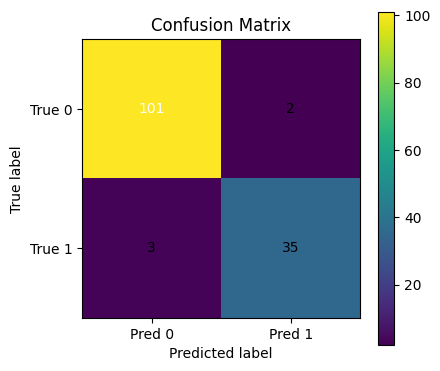

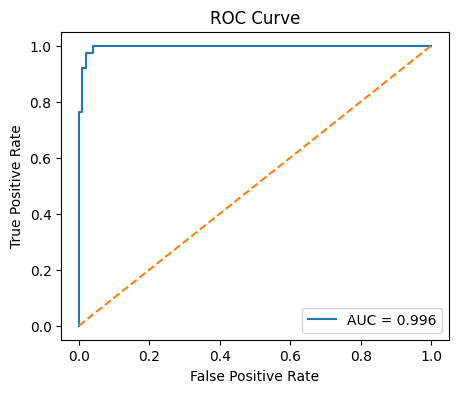

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig = plt.figure(figsize=(4.5, 4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Pred 0','Pred 1'])
plt.yticks(tick_marks, ['True 0','True 1'])
plt.xlabel("Predicted label")
plt.ylabel("True label")

# Label each cell
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Interpretation: Coefficients
coefs = pd.Series(model.coef_.ravel(), index=X.columns)
coef_top = coefs.reindex(coefs.abs().sort_values(ascending=False).head(15).index)
display_df = pd.DataFrame({"feature": coef_top.index, "coef": coef_top.values, "abs_coef": coef_top.abs().values})
print(display_df.sort_values(by="abs_coef", ascending=False))

                      feature      coef  abs_coef
0                      result  2.184313  2.184313
1                    A9_Score  1.375135  1.375135
2                    A5_Score  1.326479  1.326479
3                    A7_Score  1.322214  1.322214
4                    A4_Score  1.221130  1.221130
5                    A1_Score  1.134273  1.134273
6                    A8_Score  1.053691  1.053691
7                    A2_Score  1.022274  1.022274
8                   A10_Score  1.018128  1.018128
9                    A6_Score  1.004613  1.004613
10                   A3_Score  0.994212  0.994212
11       contry_of_res_France  0.377578  0.377578
12       contry_of_res_Jordan -0.363528  0.363528
13  ethnicity_Middle Eastern  -0.352809  0.352809
14       contry_of_res_Russia  0.329422  0.329422
